In [3]:
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Image
import os
import subprocess
import shutil


In [46]:
global OUTPUT_DIRECTORY, MAIN_OUTPUT_FILE

OUTPUT_DIRECTORY = '../threedhst/OUTPUT'
MAIN_OUTPUT_FILE = 'goodss_3dhst.v4.1'



def readEazyBinary(CACHE_FILE='Same'):
    """
tempfilt, coeffs, temp_sed, pz = readEazyBinary(MAIN_OUTPUT_FILE='photz', \
                                                OUTPUT_DIRECTORY='./OUTPUT', \
                                                CACHE_FILE = 'Same')

    Read Eazy BINARY_OUTPUTS files into structure data.

    By default assumes that CACHE_FILE is MAIN_OUTPUT_FILE+'.tempfilt'.
    Specify the full filename if otherwise.
    """

    root = OUTPUT_DIRECTORY + '/' + MAIN_OUTPUT_FILE

    ###### .tempfilt
    if CACHE_FILE == 'Same':
        CACHE_FILE = root + '.tempfilt'

    f = open(CACHE_FILE, 'rb')

    s = np.fromfile(file=f, dtype=np.int32, count=4)
    NFILT = s[0]
    NTEMP = s[1]
    NZ = s[2]
    NOBJ = s[3]
    tempfilt = np.fromfile(file=f, dtype=np.double, count=NFILT * NTEMP * NZ).reshape((NZ, NTEMP, NFILT)).transpose()
    lc = np.fromfile(file=f, dtype=np.double, count=NFILT)
    zgrid = np.fromfile(file=f, dtype=np.double, count=NZ)
    fnu = np.fromfile(file=f, dtype=np.double, count=NFILT * NOBJ).reshape((NOBJ, NFILT)).transpose()
    efnu = np.fromfile(file=f, dtype=np.double, count=NFILT * NOBJ).reshape((NOBJ, NFILT)).transpose()

    f.close()

    tempfilt = {'NFILT': NFILT, 'NTEMP': NTEMP, 'NZ': NZ, 'NOBJ': NOBJ, \
                'tempfilt': tempfilt, 'lc': lc, 'zgrid': zgrid, 'fnu': fnu, 'efnu': efnu}

    ###### .coeff
    f = open(root + '.coeff', 'rb')

    s = np.fromfile(file=f, dtype=np.int32, count=4)
    NFILT = s[0]
    NTEMP = s[1]
    NZ = s[2]
    NOBJ = s[3]
    coeffs = np.fromfile(file=f, dtype=np.double, count=NTEMP * NOBJ).reshape((NOBJ, NTEMP)).transpose()
    izbest = np.fromfile(file=f, dtype=np.int32, count=NOBJ)
    tnorm = np.fromfile(file=f, dtype=np.double, count=NTEMP)

    f.close()

    coeffs = {'NFILT': NFILT, 'NTEMP': NTEMP, 'NZ': NZ, 'NOBJ': NOBJ, \
              'coeffs': coeffs, 'izbest': izbest, 'tnorm': tnorm}

    ###### .temp_sed
    f = open(root + '.temp_sed', 'rb')
    s = np.fromfile(file=f, dtype=np.int32, count=3)
    NTEMP = s[0]
    NTEMPL = s[1]
    NZ = s[2]
    templam = np.fromfile(file=f, dtype=np.double, count=NTEMPL)
    temp_seds = np.fromfile(file=f, dtype=np.double, count=NTEMPL * NTEMP).reshape((NTEMP, NTEMPL)).transpose()
    da = np.fromfile(file=f, dtype=np.double, count=NZ)
    db = np.fromfile(file=f, dtype=np.double, count=NZ)

    f.close()

    temp_sed = {'NTEMP': NTEMP, 'NTEMPL': NTEMPL, 'NZ': NZ, \
                'templam': templam, 'temp_seds': temp_seds, 'da': da, 'db': db}

    ###### .pz
    if os.path.exists(root + '.pz'):
        f = open(root + '.pz', 'rb')
        s = np.fromfile(file=f, dtype=np.int32, count=2)
        NZ = s[0]
        NOBJ = s[1]
        chi2fit = np.fromfile(file=f, dtype=np.double, count=NZ * NOBJ).reshape((NOBJ, NZ)).transpose()

        ### This will break if APPLY_PRIOR No
        s = np.fromfile(file=f, dtype=np.int32, count=1)

        if len(s) > 0:
            NK = s[0]
            kbins = np.fromfile(file=f, dtype=np.double, count=NK)
            priorzk = np.fromfile(file=f, dtype=np.double, count=NZ * NK).reshape((NK, NZ)).transpose()
            kidx = np.fromfile(file=f, dtype=np.int32, count=NOBJ)
            pz = {'NZ': NZ, 'NOBJ': NOBJ, 'NK': NK, 'chi2fit': chi2fit, 'kbins': kbins, 'priorzk': priorzk,
                  'kidx': kidx}
        else:
            pz = None

        f.close()

    else:
        pz = None

    if False:
        f = open(root + '.zbin', 'rb')
        s = np.fromfile(file=f, dtype=np.int32, count=1)
        NOBJ = s[0]
        z_a = np.fromfile(file=f, dtype=np.double, count=NOBJ)
        z_p = np.fromfile(file=f, dtype=np.double, count=NOBJ)
        z_m1 = np.fromfile(file=f, dtype=np.double, count=NOBJ)
        z_m2 = np.fromfile(file=f, dtype=np.double, count=NOBJ)
        z_peak = np.fromfile(file=f, dtype=np.double, count=NOBJ)
        f.close()

    ###### Done.
    return tempfilt, coeffs, temp_sed, pz



#-------------------------------------------------------------------------------------------

def SED(id):
    tempfilt, coeffs, temp_seds, pz = readEazyBinary(CACHE_FILE='Same')
    idx = id - 1
    params = 25.0  # params['PRIOR_ABZP'] = 25.0
    scale_flambda = 1.e-17
    flam_factor = 10 ** (-0.4 * (params + 48.6)) * 3.e18 / scale_flambda



    zpf = np.ones(tempfilt['NFILT'])

    zpfactors = np.dot(zpf.reshape(tempfilt['NFILT'], 1), \
                       np.ones(tempfilt['NOBJ']).reshape(1, tempfilt['NOBJ']))
    tempfilt['fnu'] *= zpfactors
    tempfilt['efnu'] *= zpfactors
    lci = tempfilt['lc'].copy()

    missing = (tempfilt['fnu'][:, idx] < -99) | (tempfilt['efnu'][:, idx] < 0)
    fobs = tempfilt['fnu'][:, idx] / lci ** 2 * flam_factor
    efobs = tempfilt['efnu'][:, idx] / lci ** 2 * flam_factor
    fobs[missing] = -99
    efobs[missing] = -99
    # print lci, tempfilt['fnu'][:,idx], tempfilt['efnu'][:,idx]



    ##### Broad-band SED
    obs_sed = np.dot(tempfilt['tempfilt'][:, :, coeffs['izbest'][idx]], \
                     coeffs['coeffs'][:, idx]) / (lci) ** 2 * flam_factor

    zi = tempfilt['zgrid'][coeffs['izbest'][idx]]
    
    x  = np.dot(tempfilt['tempfilt'][:, :, coeffs['izbest'][idx]],  coeffs['coeffs'][:, idx])
        
    print(zi)
    ###### Full template SED, observed frame
    lambdaz = temp_seds['templam'] * (1 + zi)
    temp_sed = np.dot(temp_seds['temp_seds'], coeffs['coeffs'][:, idx])

    ts = np.dot(temp_seds['temp_seds'], coeffs['coeffs'][:, idx]) * 10 ** (-0.4 * (params + 48.6))
    print('k')
    ##### IGM absorption
    lim1 = np.where(temp_seds['templam'] < 912)
    lim2 = np.where((temp_seds['templam'] >= 912) & (temp_seds['templam'] < 1026))
    lim3 = np.where((temp_seds['templam'] >= 1026) & (temp_seds['templam'] < 1216))

    

    if lim1[0].size > 0:
        temp_sed[lim1] *= 0.
    if lim2[0].size > 0:
        temp_sed[lim2] *= 1. - temp_seds['db'][coeffs['izbest'][idx]]
    if lim3[0].size > 0:
        temp_sed[lim3] *= 1. - temp_seds['da'][coeffs['izbest'][idx]]

    

    temp_sed /= (1 + zi) ** 2
    temp_sed *= (1 / 5500.) ** 2 
    temp_sed *= flam_factor
    
    
    return lambdaz, temp_sed, lci, obs_sed, fobs, efobs, \
               tempfilt['fnu'][:, idx]* 10 ** (-0.4 * (params + 48.6)), x* 10 ** (-0.4 * (params + 48.6)),\
                    tempfilt['efnu'][:, idx] * 10 ** (-0.4 * (params + 48.6)), ts
                         

            
            
            
            
    # Output variables are as follows:
    #  lambdaz: full best-fit template (observed) wavelength, interpolated at WAVELENGTH_GRID
    #  temp_sed:    flux (F_lambda)  - лучший фит
    #  lci: filter pivot wavelengths   - среднии длины волн из фильтров
    #  fobs: observed fluxes, including zeropoint offsets if used, F_lambda  - это реально наблюдаемые поток и ошибка
    #  efobs: observed flux errors,
    #  obs_sed  - теоретически предсказанный поток
    print('END')


In [66]:
def flus_nu(tmp,zi): #функция перевода
    g = len(tmp)
    fl = np.zeros(g)
    for i in range(g):
        fl[i] = tmp[i]*((1+zi)*5500)**2 / (3*(10**18))* 10**(-17)
    return fl

In [47]:
lambdaz, temp_sed, lci, obs_sed, fobs, efobs, fobs_nu, obs_sed_nu, efobs_nu, ts = SED(28664)

6.53770050876
k


In [72]:
lrange=[3000,8.e4]
pair_cat = np.genfromtxt('check_pairs.dat')

k = 0
l = 0
while k < (len(pair_cat) - 1):
    few = []
    one = k

    for i in range(k + 1, len(pair_cat)):

        if abs(pair_cat[k, 1] - pair_cat[i, 1]) < 50:
            few.append(i)
            k += 1
        else:
            k += 1
            l += 1
            break
    
    if (len(few) == 2):
        
        # SED_in_nu ----------------------------------------------------------------------------------------------------
        lambdaz, temp_sed, lci, obs_sed, fobs, efobs, fobs_nu, obs_sed_nu, efobs_nu, ts = SED(pair_cat[one, 0])
        lambdaz2, temp_sed2, lci2, obs_sed2, fobs2, efobs2, fobs_nu2, obs_sed_nu2, efobs_nu2, ts2 = SED(int(pair_cat[few, 0][0]))
        lambdaz3, temp_sed3, lci3, obs_sed3, fobs3, efobs3, fobs_nu3, obs_sed_nu3, efobs_nu3, ts3 = SED(int(pair_cat[few, 0][1]))

        plt.close()
        f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(23, 23))

        #метод 1
        ax1.plot(lambdaz, ts*10**29, lw=5, color='darkred', label='Best_Fit')
        ax1.scatter(lci, obs_sed_nu*10**29, color='orange', zorder=2, s=160, label='Predict')
        ax1.errorbar(lci, fobs_nu*10**29, yerr=efobs_nu*10**29/2, fmt='o', label='Observed fluxes', markersize='15', elinewidth=2)
        ax1.legend(loc='upper left', fontsize=20)

        
        
        h2 = flus_nu(temp_sed2,6.53770050876)
        ax2.plot(lambdaz2, h2*10**29, lw=5, color='b', label='Best_Fit')
        ax2.plot(lambdaz2, ts2*10**29, lw=5, color='y', label='Best_Fit')
        ax2.scatter(lci2, obs_sed_nu2*10**29, color='orange', zorder=2, s=160, label='Predict')
        ax2.errorbar(lci2, fobs_nu2*10**29, yerr=efobs_nu2*10**29/2, fmt='o', label='Observed fluxes', markersize='15', elinewidth=2)
        ax2.legend(loc='upper left', fontsize=20)
        
        
        
        ax3.plot(lambdaz3, ts3*10**29, lw=5, color='darkgreen', label='Best_Fit')
        ax3.scatter(lci3, obs_sed_nu3*10**29, color='orange', zorder=2, s=160, label='Predict')
        ax3.errorbar(lci3, fobs_nu3*10**29, yerr=efobs_nu3*10**29/2, fmt='o', label='Observed fluxes', markersize='15', elinewidth=2)
        ax3.legend(loc='upper left', fontsize=20)




        ax1.set_xlim([3e3, 1.5e5])
        ax1.set_ylim(-0.05 * max(obs_sed_nu*10**29), 1.1 * max(fobs_nu*10**29))
        ax1.set_xscale("log", nonposx='clip')
        #ax1.xaxis.set_tick_params(labelsize=18)
        ax1.yaxis.set_tick_params(labelsize=18)



        ax2.set_xlim([3e3, 1.5e5])
        ax2.set_ylim(-0.05 * max(obs_sed_nu2*10**29), 1.1 * max(fobs_nu2*10**29))
        ax2.set_xscale("log", nonposx='clip')
        #ax2.xaxis.set_tick_params(labelsize=18)
        ax2.yaxis.set_tick_params(labelsize=20)

        ax3.set_xlim([3e3, 1.5e5])
        ax3.set_ylim(-0.05 * max(obs_sed_nu3*10**29), 1.1 * max(fobs_nu3*10**29))
        ax3.set_xscale("log", nonposx='clip')
        ax3.xaxis.set_tick_params(labelsize=20)
        ax3.yaxis.set_tick_params(labelsize=20)

        
        ax1.set_ylabel(r'$f_\nu$ [$\mu$$Jy$]', fontsize=22)
        ax2.set_ylabel(r'$f_\nu$ [$\mu$$Jy$]', fontsize=22)
        ax3.set_xlabel(r'$\lambda%s$ [$\AA$]', fontsize=22)
        ax3.set_ylabel(r'$f_\nu$ [$\mu$$Jy$]', fontsize=22)

        f.subplots_adjust(hspace=0.1)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.savefig('XSED_' + str(l) + '.png',format='png', dpi =300)
        plt.close()
        #plt.show()
        
        '''
        plt.close()
        # SED_in_lambda ----------------------------------------------------------------------------------------------------
        lambdaz, temp_sed, lci, obs_sed, fobs, efobs, fobs_nu, obs_sed_nu, efobs_nu, ts = SED(pair_cat[one, 0])
        lambdaz2, temp_sed2, lci2, obs_sed2, fobs2, efobs2, fobs_nu2, obs_sed_nu2, efobs_nu2,ts2 = SED(int(pair_cat[few, 0][0]))
        lambdaz3, temp_sed3, lci3, obs_sed3, fobs3, efobs3, fobs_nu3, obs_sed_nu3, efobs_nu3,ts3 = SED(int(pair_cat[few, 0][1]))

        f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(23, 23))

        ax1.plot(lambdaz, temp_sed, lw=5, color='darkred', label='Best_Fit')
        ax1.scatter(lci, obs_sed, color='orange', zorder=2, s=160, label='Predict')
        ax1.errorbar(lci, fobs, yerr=efobs, fmt='o', label='Observed fluxes', markersize='15', elinewidth=2)
        ax1.legend(loc='upper right', fontsize=20)


        ax2.plot(lambdaz2, temp_sed2, lw=5, color='b', label='Best_Fit')
        ax2.scatter(lci2, obs_sed2 , color='orange', zorder=2, s=160, label='Predict')
        ax2.errorbar(lci2, fobs2, yerr=efobs2, fmt='o', label='Observed fluxes',markersize='15', elinewidth=2)
        ax2.legend(loc='upper right', fontsize=20)


        ax3.plot(lambdaz3, temp_sed3, lw=5, color='darkgreen', label='Best_Fit')
        ax3.scatter(lci3, obs_sed3, color='orange', zorder=2, s=160, label='Predict')
        ax3.errorbar(lci3, fobs3, yerr=efobs3, fmt='o', label='Observed fluxes',markersize='15', elinewidth=2)
        ax3.legend(loc='upper right', fontsize=20)

        ax1.set_xlim([3e3, 1.5e5])
        ax1.set_ylim(-0.05 * max(obs_sed), 1.1 * max(fobs))
        ax1.set_xscale("log", nonposx='clip')
        ax1.yaxis.set_tick_params(labelsize=18)

        ax2.set_xlim([3e3, 1.5e5])
        ax2.set_ylim(-0.05 * max(obs_sed2), 1.1 * max(fobs2))
        ax2.set_xscale("log", nonposx='clip')
        ax2.yaxis.set_tick_params(labelsize=20)

        ax3.set_xlim([3e3, 1.5e5])
        ax3.set_ylim(-0.05 * max(obs_sed3), 1.1 * max(fobs3))
        ax3.set_xscale("log", nonposx='clip')
        ax3.xaxis.set_tick_params(labelsize=20)
        ax3.yaxis.set_tick_params(labelsize=20)

       
        ax1.set_ylabel(r'$f_\lambda$', fontsize=22)
        ax2.set_ylabel(r'$f_\lambda$', fontsize=22)
        ax3.set_xlabel(r'$\lambda%s$ [$\AA$]', fontsize=22)
        ax3.set_ylabel(r'$f_\lambda$', fontsize=22)

        f.subplots_adjust(hspace=0.2)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.savefig('LSED_' + str(l) + '.png', format='png', dpi =300)
        plt.close()
        '''
print('Ready')

/home/tuberozova/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:138: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tuberozova/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:139: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tuberozova/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:140: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tuberozova/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:149: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tuberozova/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:151: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tuberozova/ana

6.17186339754
k
6.53770050876
k
8.01620143603
k
Ready




SED_in nu


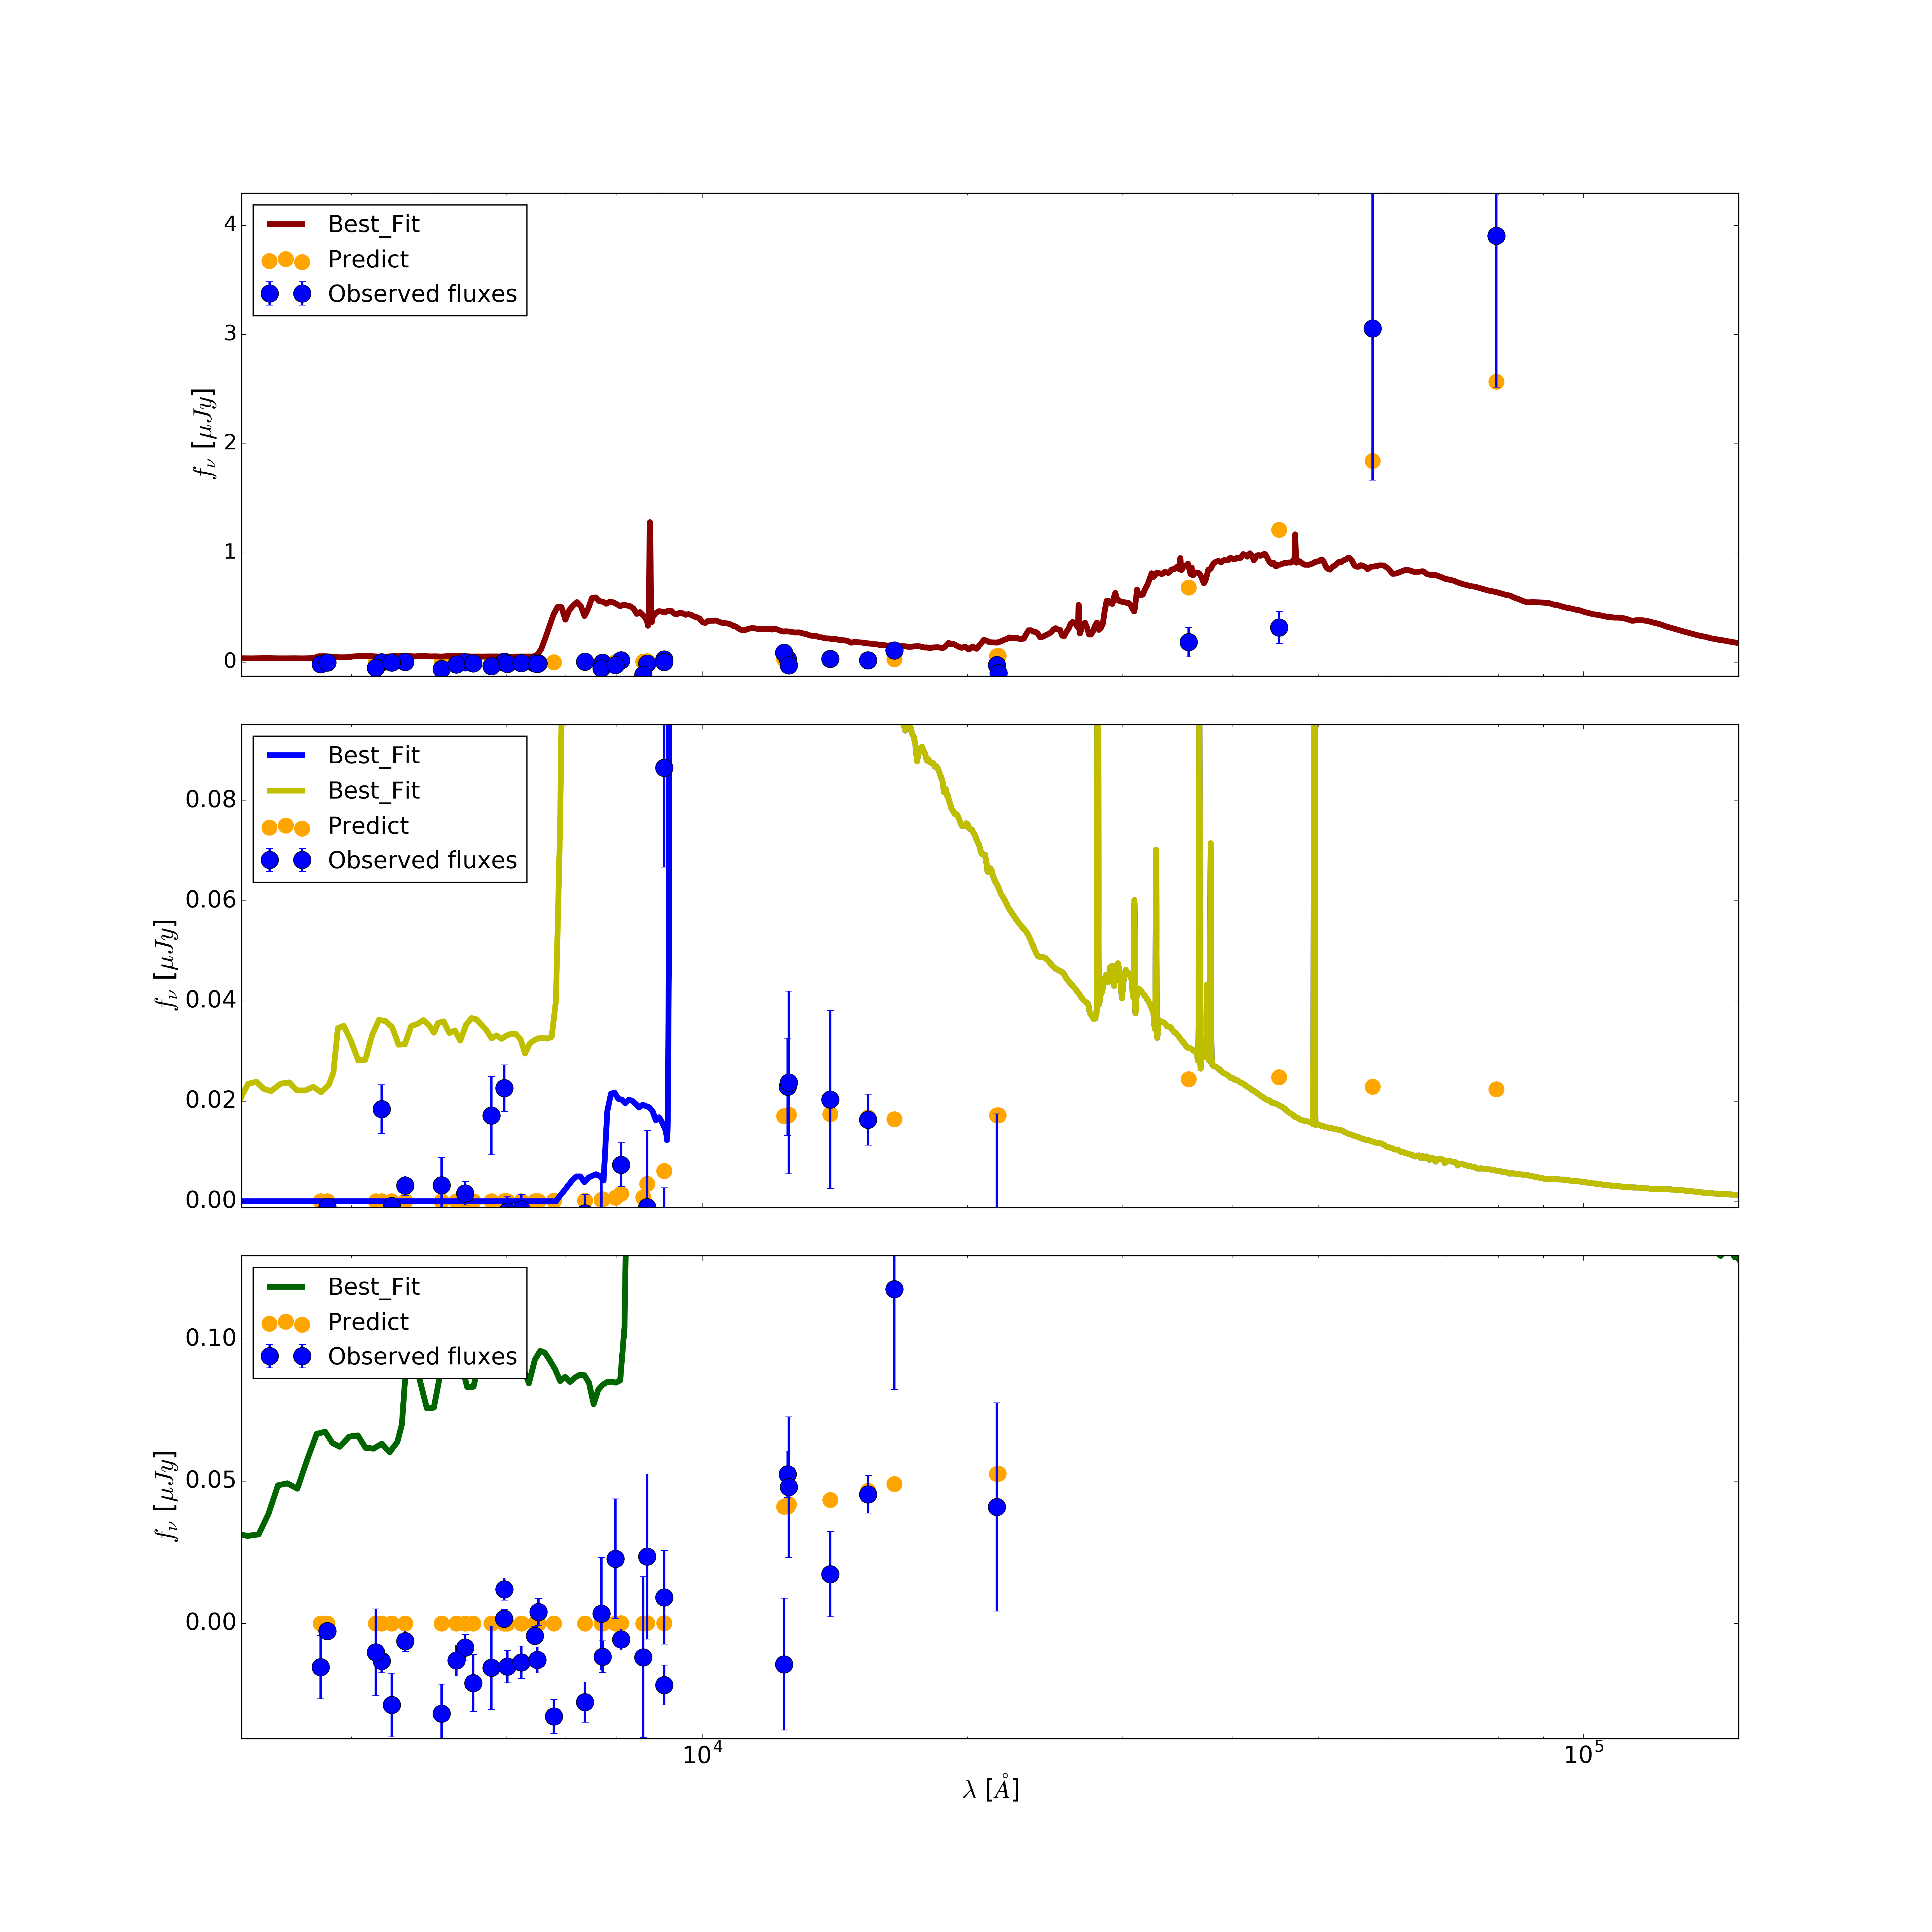

In [73]:
#print('SED_in lambda')
#im = Image('LSED_0.png')
#display(im)
print('')
print('')
print('SED_in nu')
img = Image('XSED_0.png')
display(img)